In [17]:
import os
import time
import glob
import requests
from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F

from sklearn.metrics import f1_score

import torchvision
from torchvision import datasets, transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2, style='whitegrid')

# device_num = 0
# torch.cuda.set_device(device_num)

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
import torch
import torchvision.transforms as transforms
from torch import nn
import torch.nn.functional as F

from PIL import Image
from torch.utils.data import Dataset, random_split

# Условие
В этом задании вам предстоит реализовать модель **U-Net** для задачи семантической сегментации и исследовать ее свойства. Для оценки качества вам понадобится реализовать метрику IoU. Полученную сетку вы примените к своему изображению.


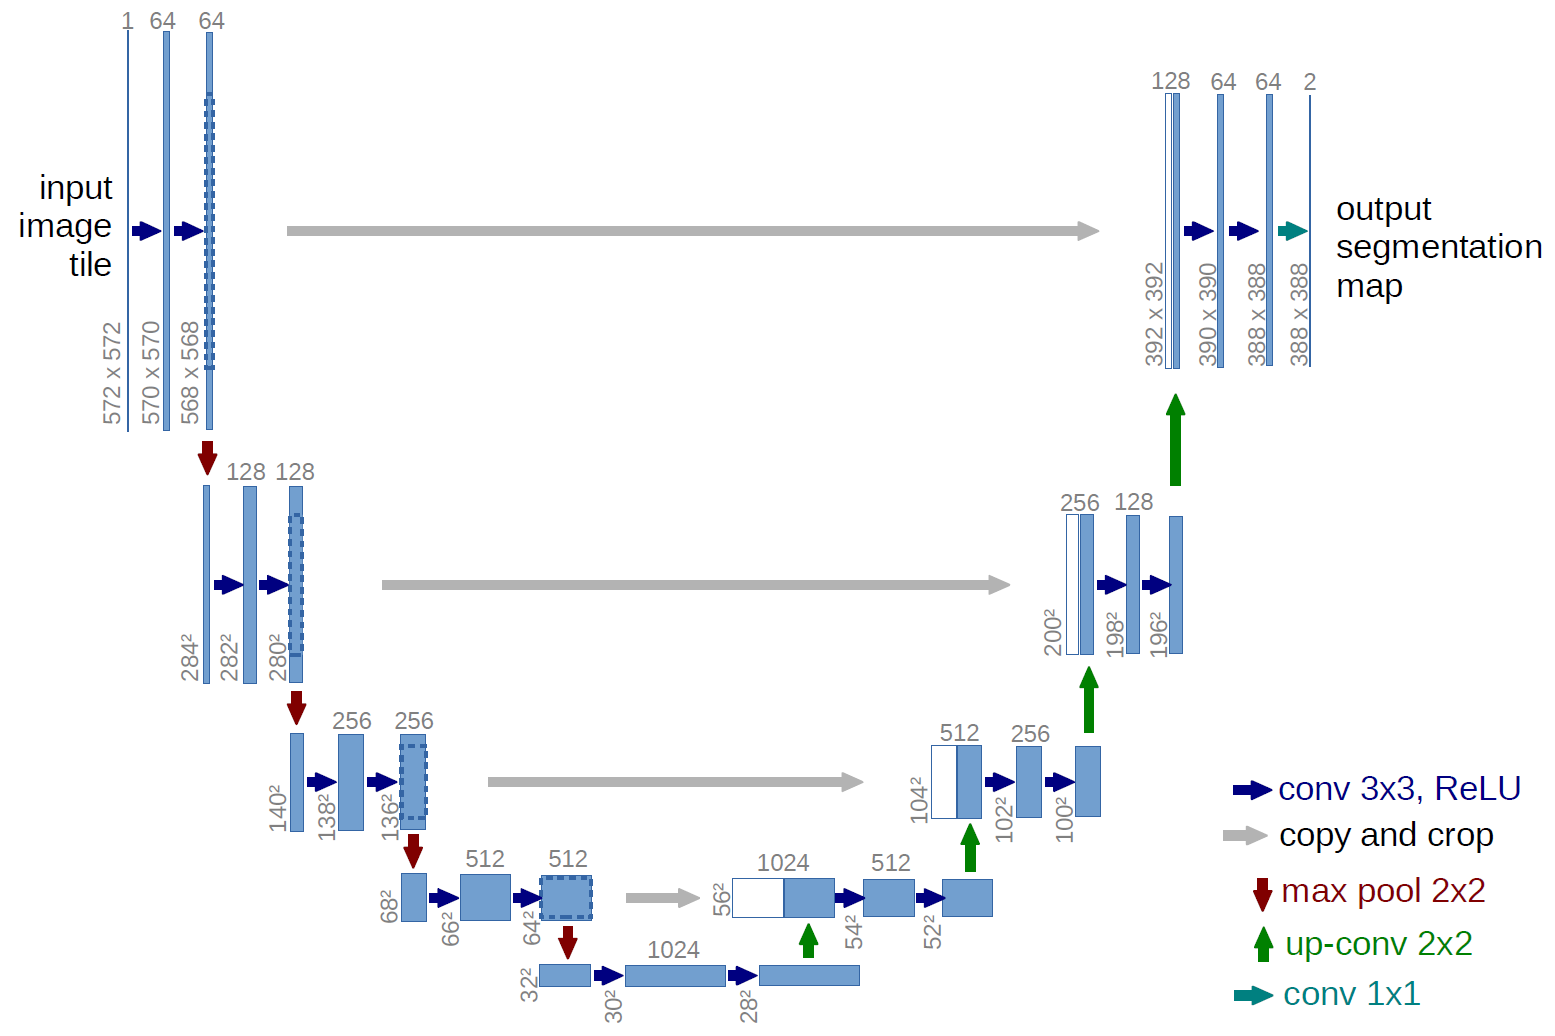

# 1. Данные 
Мы прдлагаем вам поработать с подмножеством датасета [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge) с Kaggle. Далее расписан процес загрузки данных.

Реализация функций для скачивания файла и получения его id.

In [16]:
def upload_file_from_gdrive(gdrive_file_id, outfile) -> None:
    """
    Скачивает файл из Google Drive по ID.
    gdrive_file_id -- id файла на гугл-диске.
    outfile -- путь до файла, в котором будет сохранено изображение.
    """
    
    upload_cmd = (
        "wget --load-cookies /tmp/cookies.txt"
        " \"https://docs.google.com/uc?export=download&confirm=$("
        " wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies"
        f" --no-check-certificate 'https://docs.google.com/uc?export=download&id={gdrive_file_id}'"
        f" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\\1\\n/p')&id={gdrive_file_id}\" "
        f" -O {outfile} && rm -rf /tmp/cookies.txt"
    )
    subprocess.check_call(upload_cmd, shell=True)

def get_gdrive_file_id(link):
    return link.split('/')[5]

Определим пути к данным. 

In [4]:
# Путь до zip-файла с даннными
ZIP_PATH = "carvana.zip"

# Путь до папки с данными
DATA_PATH = "carvana"

Загрузим данные с гугл-диска.

In [5]:
%%time

# Ссылка на архив с данными
link = "https://drive.google.com/file/d/1VxK_dxyVrvmkGPaPDaCvWoEj2qYW5oaF/view?usp=sharing"

# ID файла на диске
file_id = get_gdrive_file_id(link)
print("file ID:", file_id)

# Загрузка файла с диска
upload_file_from_gdrive(file_id, ZIP_PATH)
print(f"Данные загружены в {DATA_PATH}")

file ID: 1VxK_dxyVrvmkGPaPDaCvWoEj2qYW5oaF
Данные загружены в carvana
CPU times: user 47.9 ms, sys: 14.2 ms, total: 62.2 ms
Wall time: 10.3 s


Разархивируем данные.

In [6]:
%%time
! unzip $ZIP_PATH -d $DATA_PATH

Archive:  carvana.zip
replace carvana/test/00087a6bd4dc_15.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: CPU times: user 1.61 s, sys: 272 ms, total: 1.88 s
Wall time: 9min 52s


Данные уже разделены на трейн и тест. В папках `train` и `train_masks` лежат изображения автомобилей и из маски соответсвенно. Аналогично для папок `test` и `test_masks`.  Как подобает джентельменам и честным дамам, вы не будете использовать данные из тестового набора для обучения.

In [19]:
! ls $DATA_PATH

test  test_masks  train  train_masks


Изображения и маски имеют одинаковое начало названия. Название файла маски отличается тем, что есть оконочание `_mask`, а также сам файл имеет другой формат &mdash; `gif` вместо `jpg`. Так можно получить изображение и его маску из трейна.



In [8]:
img_name = "0cdf5b5d0ce1_01.jpg"
splitted = img_name.split('.')
mask_name = splitted[0] + "_mask" + ".gif"

img_path = os.path.join(DATA_PATH, "train", img_name)
mask_path = os.path.join(DATA_PATH, "train_masks", mask_name)

Визуализруем изображение и маску.

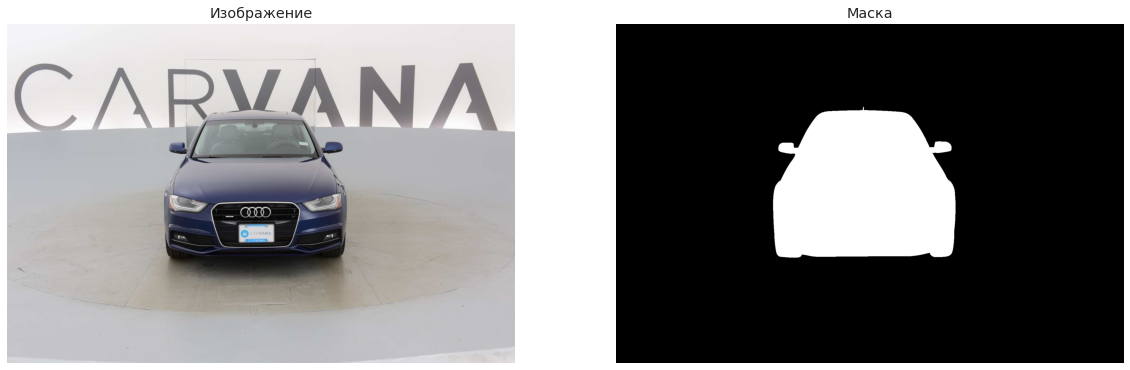

In [9]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title("Изображение")
plt.imshow(Image.open(img_path))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Маска")
plt.imshow(Image.open(mask_path))
plt.axis("off");

Реализуем класс датасет для задачи семантической сегментации. Советуем внимательно ознакомиться к ниже представленным классом. Он может вам в будующем пригодиться. Чтобы создать свой класс датасет, нужно наследовать его от класса `Dataset` из torch.utils.data, и переопределить функции `__len__` и `__getitem__`.  

In [128]:
class CarvanaDataset(Dataset):
    """ 
    Carvana features dataset.  
    Override torch Dataset class to implements reading from h5 files
    """

    def __init__(self, data_path, mask_path, input_size=(160, 240)):
        """
        Args:
            data_path: путь до изображений.
            mask_path: путь до масок изображений.
        """
        self.data_path = data_path
        self.mask_path = mask_path

        # Файлы с изображениями и масками
        self.files = os.listdir(data_path)
        self.mask_files = os.listdir(self.mask_path)

        assert len(self.files) == len(self.mask_files)

        # Сортируем файлы, чтобы было соответствие
        # между изображениями и масками за счет порядка следования.
        self.files.sort()
        self.mask_files.sort()

        # Преобразование для изображений
        self.transform = transforms.Compose([                                
            transforms.Resize(input_size),
            transforms.ToTensor(),
        ])
        # Преобразование для масок
        self.transform_mask = transforms.Compose([
            self.transform,
            transforms.Grayscale(num_output_channels=1),
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Загружаем изображение и маску
        file_name = os.path.join(self.data_path, self.files[idx])
        mask_name = os.path.join(self.mask_path, self.mask_files[idx])

        # Пробразуем изображение и маску
        input = self.transform(Image.open(file_name))
        target = self.transform(Image.open(mask_name))

        # Приводим таргет/маску к такому виду, 
        # чтобы его значения были от 0 до 1
        target = (target > 0).long()

        return input, target

Получим датасет из данных. Разделим его на обучающую выборку и валидационную. Можете поменять разделение, но валидация должна присутствовать.

In [11]:
# Датасет с данными для обучения и вадидации
dataset = CarvanaDataset(os.path.join(DATA_PATH, "train"), 
                         os.path.join(DATA_PATH, "train_masks"))

# Разделение на обучающую и валидационную части
val_ratio = 0.2
data_len = len(dataset)
val_len = int(data_len * val_ratio)
train_len = data_len - val_len
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(
    dataset, lengths=(train_len, val_len), generator=generator)

# Тестовый датасет
test_dataset = CarvanaDataset(os.path.join(DATA_PATH, "test"), 
                         os.path.join(DATA_PATH, "test_masks"))

In [12]:
train_dataset[40][0].shape

torch.Size([3, 160, 240])

Значения в маске и количество значений: (array([0, 1]), array([33747,  4653]))


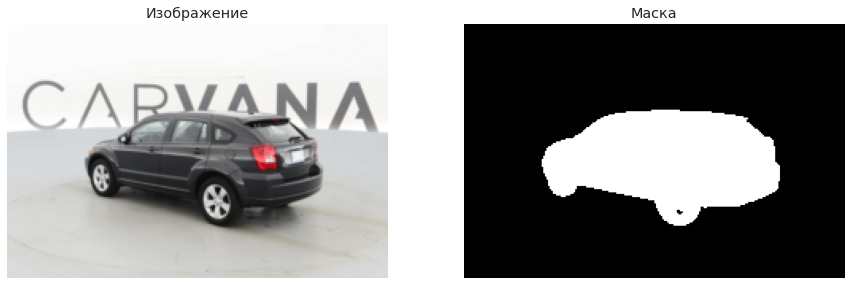

In [20]:
i = 111

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.title("Изображение")

plt.imshow(train_dataset[i][0].permute(1, 2, 0))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Маска")
plt.imshow(train_dataset[i][1].squeeze(), cmap='Greys_r')
plt.axis("off");

print("Значения в маске и количество значений:", np.unique(dataset[i][1], return_counts=True))

# 2. Релизация метрики IoU
Реализуйте метрику IoU. Она вам понадобится далее для оценивания результатов предсказания модели.


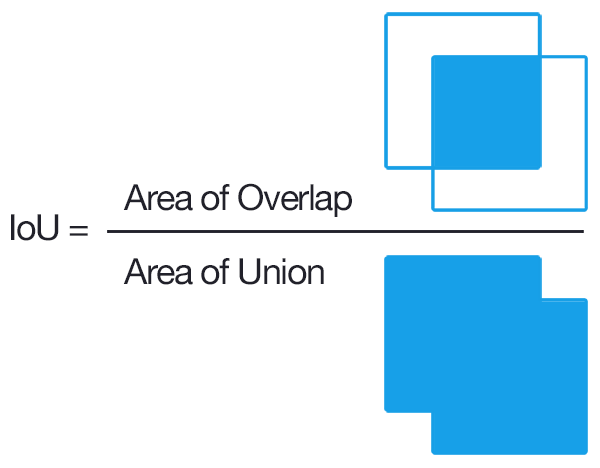

Ниже представлен пример функции. Вы можете ее изменить так, как вам удобнее, но проверяющим должно быть все понятно.

In [85]:
def iou(predicted_mask_batch, target_mask_batch):
    """ Считает IoU для всех элементов батча """
    
    iou = np.logical_and(predicted_mask_batch, target_mask_batch).sum(axis=(1, 2)) / np.logical_or(predicted_mask_batch, target_mask_batch).sum(axis=(1, 2))
    return iou

# 3. Реализация модели, обучение и преодоление порогов
- Реализуйте модель U-Net.
- Напишите пайплайн обучения и обучите модель.
  - Обязательно сохраняйте веса модели, например после каждого улучшения метрики на валидации. 
  - Сохраняйте историю обучения. 
  - Визуализируйте предсказания (маски) для некоторых заранее выбранных изображений во время обучения, можно с определенным интервалом.
  - Визуализируетй графики лоссов и метрик во время обучения, можно с определенным интревалом.
- Протестируйте модель на тестеовых данных.




In [23]:
class ConvSeq(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1), # padding=1 ?
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.seq(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.seq = nn.Sequential(nn.MaxPool2d(2), ConvSeq(in_channels, out_channels))
        
    def forward(self, x):
        return self.seq(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvSeq(in_channels, out_channels)

    def forward(self, x, copy):
        x = self.up(x)
        concat = torch.cat([copy, x], dim=1)
        out = self.conv(concat)
        return out

In [24]:
class MyUnet(nn.Module):
    def __init__(self):
        super(MyUnet, self).__init__()

        self.start = ConvSeq(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.finish = nn.Conv2d(64, 2, 1)

    def forward(self, input):
        layer1 = self.start(input)
        layer2 = self.down1(layer1)
        layer3 = self.down2(layer2)
        layer4 = self.down3(layer3)
        layer5 = self.down4(layer4)
        layer6 = self.up1(layer5, layer4)
        layer7 = self.up2(layer6, layer3)
        layer8 = self.up3(layer7, layer2)
        layer9 = self.up4(layer8, layer1)
        out = self.finish(layer9)
        return out

In [25]:
def plot_learning_curves(history):
    '''
    Функция для вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    # sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [39]:
batch_size = 16

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [86]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=50,
    save_path=None,
    patience=5
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :param save_path: путь, куда сохранять модель

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in tqdm(train_batch_gen):
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Логиты на выходе модели
            logits = model(X_batch)
            
            # Подсчитываем лосс
            loss = criterion(logits, y_batch.squeeze(1).to(device))

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()
            
            # Сохраяняем лоссы и точность на трейне
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += iou(y_batch.cpu().numpy().squeeze(1), y_pred).mean()

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Логиты, полученные моделью
            logits = model(X_batch)

            # Лосс на валидации
            loss = criterion(logits, y_batch.squeeze(1).to(device))

            # Сохраяняем лоссы и точность на валидации
            val_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += iou(y_batch.cpu().numpy().squeeze(1), y_pred).mean()
            

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)

        if save_path is not None:
          torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'history': dict(history),
          }, save_path)
      
        
    return model, history

In [78]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)

cuda


In [79]:
model = MyUnet()

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 6 of 10 took 480.871s
  training loss (in-iteration): 	0.023954
  validation loss (in-iteration): 	0.022073
  training accuracy: 			96.13 %
  validation accuracy: 			96.37 %


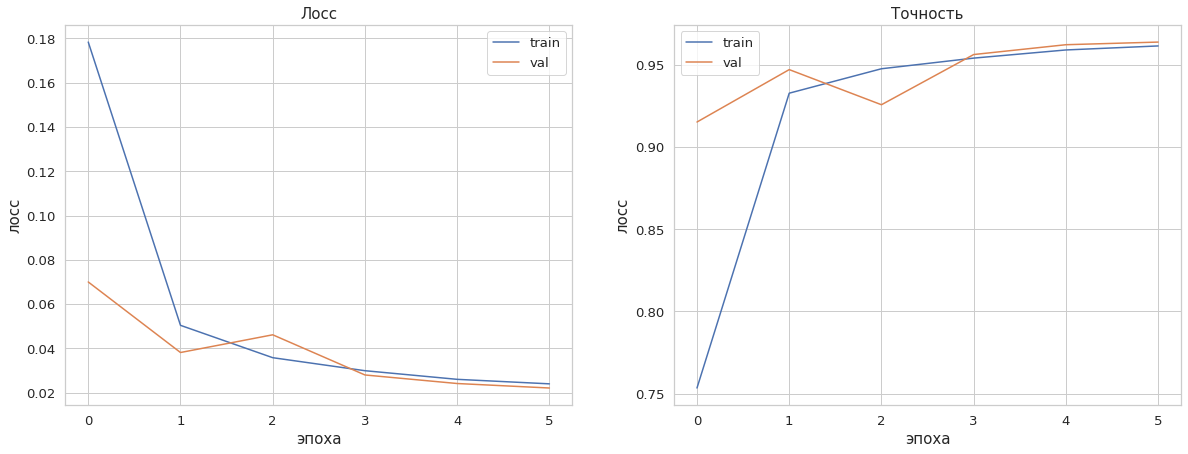

KeyboardInterrupt: ignored

In [87]:
model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10,
    save_path='drive/MyDrive/carvana/models/unet'
)

Модель обучилась за 5 эпох

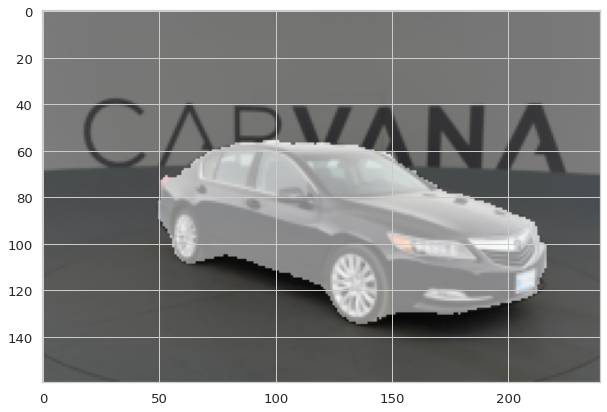

In [116]:
input_size=(160, 240)
transform = transforms.Compose([                                
            transforms.Resize(input_size),
            transforms.ToTensor(),
        ])

input = transform(Image.open('carvana/test/00087a6bd4dc_15.jpg'))
input = input.reshape((1, 3, 160, 240)).to(device)

logits = model(input)
y_pred = logits.max(1)[1].detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(input.cpu().squeeze().permute(1, 2, 0))
plt.imshow(y_pred.squeeze(), cmap='Greys_r', alpha=0.5)

In [88]:
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=False)

In [89]:
test_acc = 0
for X_batch, y_batch in tqdm(test_batch_gen):
  X_batch = X_batch.to(device)
  y_batch = y_batch.to(device)

  # Логиты, полученные моделью
  logits = model(X_batch)

  y_pred = logits.max(1)[1].detach().cpu().numpy()
  test_acc += iou(y_batch.cpu().numpy().squeeze(1), y_pred).mean()

test_acc /= len(test_batch_gen)
print("  testing accuracy: \t\t\t{:.2f} %".format(test_acc * 100))



  testing accuracy: 			94.58 %


Получили очень  хороший результат на тесте 94 % точности по метрике IOU

# 4. Применение модели
Примените полученную модель к вашему изображению с машиной (не из датасета). Сделайте выводы о работе модели.

(-0.5, 799.5, 499.5, -0.5)

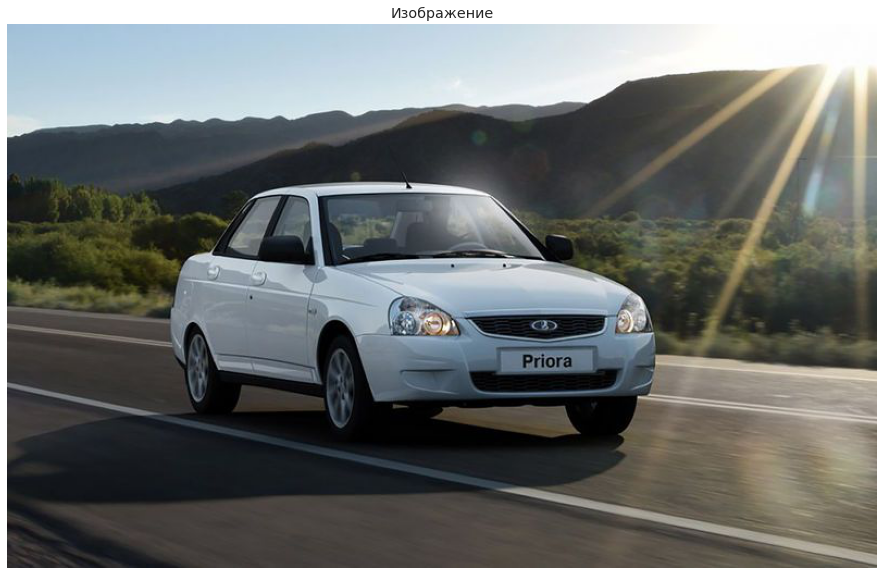

In [90]:
plt.figure(figsize=(20, 10))

plt.title("Изображение")
plt.imshow(Image.open('car.jpg'))
plt.axis("off")

In [92]:
input_size=(160, 240)
transform = transforms.Compose([                                
            transforms.Resize(input_size),
            transforms.ToTensor(),
        ])

In [100]:
input = transform(Image.open('car.jpg'))
input = input.reshape((1, 3, 160, 240)).to(device)

In [102]:
logits = model(input)

In [103]:
y_pred = logits.max(1)[1].detach().cpu().numpy()

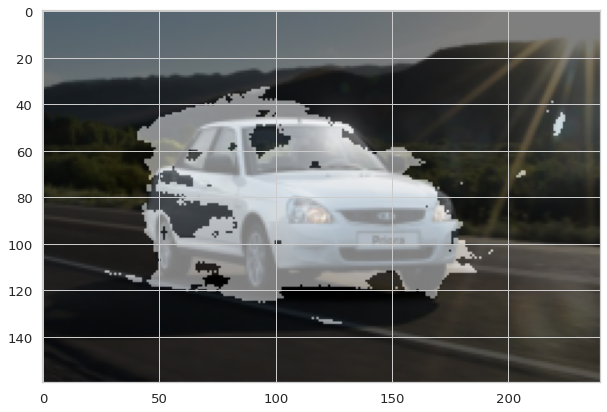

In [115]:
plt.figure(figsize=(10, 10))
plt.imshow(input.cpu().squeeze().permute(1, 2, 0))
plt.imshow(y_pred.squeeze(), cmap='Greys_r', alpha=0.5)

На данных не из датасета модель работает уже не так хорошо, но все же она правильно нашла облась где находится машина. Картинки в датасете не разнообразные, на них одинаковый фон и ракурс машин похож, нет посторонних предметов. Поэтому модель не смогла сегментировать это изображение

# 5. Исследование
Возьмите несколько изображений из датасета (от 10 до 1000) и испортите их разными способами. Например, можно вырезать квадраты из изображений. добавить шум, изменить цвета и т.д. Посчитайте среднее IoU. Сделайте вывод о возможнойти вашей модели различать машины. 

In [157]:
class CarvanaDataset(Dataset):
    """ 
    Carvana features dataset.  
    Override torch Dataset class to implements reading from h5 files
    """

    def __init__(self, data_path, mask_path, input_size=(160, 240)):
        """
        Args:
            data_path: путь до изображений.
            mask_path: путь до масок изображений.
        """
        self.data_path = data_path
        self.mask_path = mask_path

        # Файлы с изображениями и масками
        self.files = os.listdir(data_path)
        self.mask_files = os.listdir(self.mask_path)

        assert len(self.files) == len(self.mask_files)

        # Сортируем файлы, чтобы было соответствие
        # между изображениями и масками за счет порядка следования.
        self.files.sort()
        self.mask_files.sort()

        # Преобразование для изображений
        self.transform = transforms.Compose([                                
            transforms.CenterCrop(9),     # Вырезаем из центра квадрат размера input_size x input_size
            transforms.RandomAffine(5),            # Приеменяем слйчайное афинное преобразование
            transforms.Resize(input_size),
            transforms.ToTensor(),
        ])
        # Преобразование для масок
        self.transform_mask = transforms.Compose([
            self.transform,
            transforms.Grayscale(num_output_channels=1),
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Загружаем изображение и маску
        file_name = os.path.join(self.data_path, self.files[idx])
        mask_name = os.path.join(self.mask_path, self.mask_files[idx])

        # Пробразуем изображение и маску
        input = self.transform(Image.open(file_name))
        target = self.transform(Image.open(mask_name))

        # Приводим таргет/маску к такому виду, 
        # чтобы его значения были от 0 до 1
        target = (target > 0).long()

        return input, target

In [158]:
test_dataset = CarvanaDataset(os.path.join(DATA_PATH, "test"), 
                         os.path.join(DATA_PATH, "test_masks"))

In [159]:
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [162]:
test_acc = 0
for X_batch, y_batch in tqdm(test_batch_gen):
  X_batch = X_batch.to(device)
  y_batch = y_batch.to(device)

  # Логиты, полученные моделью
  logits = model(X_batch)

  y_pred = logits.max(1)[1].detach().cpu().numpy()
  test_acc += iou(y_batch.cpu().numpy().squeeze(1), y_pred).mean()

In [161]:
test_acc /= i
print("  testing accuracy: \t\t\t{:.2f} %".format(test_acc * 100))

  testing accuracy: 			23.48 %


После изменения картинок модель плохо сегментирует изображения, поэтому чтоит добавить аугментаций в обучение

## 6. Примените одну из моделей семантической сегментации из torchvision models или torchhub. 
Сравните результаты этой и вашей моделей.

In [163]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [164]:
model = model.to(device)

In [165]:
test_acc = 0
for X_batch, y_batch in tqdm(test_batch_gen):
  X_batch = X_batch.to(device)
  y_batch = y_batch.to(device)

  # Логиты, полученные моделью
  logits = model(X_batch)['out'][:, [0, 7], :, :]

  y_pred = logits.max(1)[1].detach().cpu().numpy()
  test_acc += iou(y_batch.cpu().numpy().squeeze(1), y_pred).mean()

test_acc /= len(test_batch_gen)
print("  testing accuracy: \t\t\t{:.2f} %".format(test_acc * 100))



  testing accuracy: 			0.00 %


**Получился довольно хороший скор на тесте у предобученной модели Deeplab V3. Но все же хуже чем написанная модель, потому что deeplab обучен на другом датасете**

In [166]:
from typing import List

def random_colormap(n_colors: int, alpha: float = 1) -> List[np.ndarray]:
    """ 
    Генерирует случайную палитру с фиксированной прозрачностью alpha
    по наперёд заданному количеству цветов n_colors. Палитра представляет
    собой список, каждый элемент которого — numpy.ndarray из 4 чисел 
    в диапазоне [0, 1] (т.н. RGBA формат). matplotlib и seaborn поддерживают 
    такой формат палитры без дополнительных усилий со стороны разработчика.
    """
    assert 0 <= alpha <= 1, "Параметр 'alpha' должен лежать в диапазоне [0, 1]"
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(n_colors)])[:, None] * palette
    colors = (colors % 255).numpy() / 255
    colors = np.column_stack((colors, np.full(n_colors, alpha)))
    return list(colors)


def plot_segmentation_masks(category_probs: np.ndarray, 
                            threshold: float,
                            categories: np.ndarray, 
                            categories_of_interest: np.ndarray, 
                            ax,  # холст из matplotlib
                            alpha: float, 
                            cmap: List[np.ndarray]) -> None:
    """
    Отрисовывает маски заданного подмножества категорий.
    Принимает на вход следующие аргументы:
    :param category_probs: — трёхмерный np.ndarray, 
    размерность — (число_категорий, *размер картинки), т.е. для каждого
    пикселя изображения предсказывается вероятность того, что на нём
    изображен объект из какой-то конкретной категории. Сами маски получаются
    выбором самой вероятной категории (т.е. максимизацией праводоподобия).

    :param threshold: — порог, вероятности ниже которого  не учитываются
    :param categories: — категории, на которых была обучена модель.
    :param categories_of_interest: — категории, маски которых нужно отрисовать
    :param ax: — холст (должен быть создан заранее)
    :param cmap: — RGBA-палитра цветов, по цвету на категорию
    """
    probs = np.copy(category_probs)
    probs[probs < threshold] = 0
    masks = probs.argmax(0)
    sns.heatmap(masks, cmap=cmap, ax=ax, cbar=False, linewidths=0)


def visualize_semantic_segmentation(ax,  # холст из matplotlib 
                                    original_image: Image, 
                                    category_probs: np.ndarray, 
                                    threshold: float, 
                                    categories: np.ndarray, 
                                    categories_of_interest: np.ndarray,
                                    show_original: bool = True,
                                    alpha: float = 0.5):
    """
    Функция для отрисовки результатов семантической сегментации.  
    Может отрисовывать маски поверх исходного изображения.
    Позволяет настраивать прозрачность и порог достоверности. 
    См. описание некоторых парамтеров в функции plot_segmentation_masks
    """
    ax.imshow(original_image, alpha=1. if show_original else 0)
    ax.set_axis_off()        
    n_categories = len(categories)
    plot_segmentation_masks(
        ax=ax,
        alpha=alpha,
        category_probs=category_probs,
        threshold=threshold,
        categories=categories,
        categories_of_interest=categories_of_interest,
        cmap=[(0,0,0,0)] + random_colormap(n_categories, alpha=alpha)[1:]
    )

In [167]:
class SemanticSegmentationTorchHubAPI:
    """
    Интерфейсный класс для моделей из Pytorch Hub, решающих
    задачу семантической сегментации. Принимает на вход название предобученной 
    модели, бэкенд (CUDA или CPU) и изображение в формате PIL.Image. Возвращает
    тензор вероятностей каждого из 21 классов для каждого пикселя изображения. 
    !!! Выходной тензор заранее отгружается на CPU и кастуется к np.ndarray !!!
    """
    def __init__(self, device: str = "cuda", 
                 torchub_model: str = "deeplabv3_resnet101"):
        self.device = device

        # Модель из torch hub
        self.model = torch.hub.load(
            'pytorch/vision:v0.5.0', torchub_model, pretrained=True).to(device)
        self.model.eval()

        # Трансформация картинки
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225]),
        ])
        
    def __call__(self, image: Image) -> np.ndarray:
        return self.forward(image)
    
    def detach(self) -> None:
        """
        Переводит модель на cpu.
        """
        self.model = self.model.cpu()
    
    def forward(self, image: Image) -> np.ndarray:
        """
        Получает предсказание -- сегментацию картинки.
        """
        input_batch = self._preprocess_image(image)
        with torch.no_grad():
            model_outputs = self.model(input_batch)
        category_probs = model_outputs["out"][0].cpu().numpy()
        category_probs = sklearn.preprocessing.MinMaxScaler()\
                        .fit_transform(np.ravel(category_probs)[:, None])\
                        .reshape(category_probs.shape)
        return category_probs    
    
    def _preprocess_image(self, image) -> torch.Tensor:
        """
        Преобразует картинку и создает из нее батч.
        """
        return self.transform(image).unsqueeze(0).to(self.device)

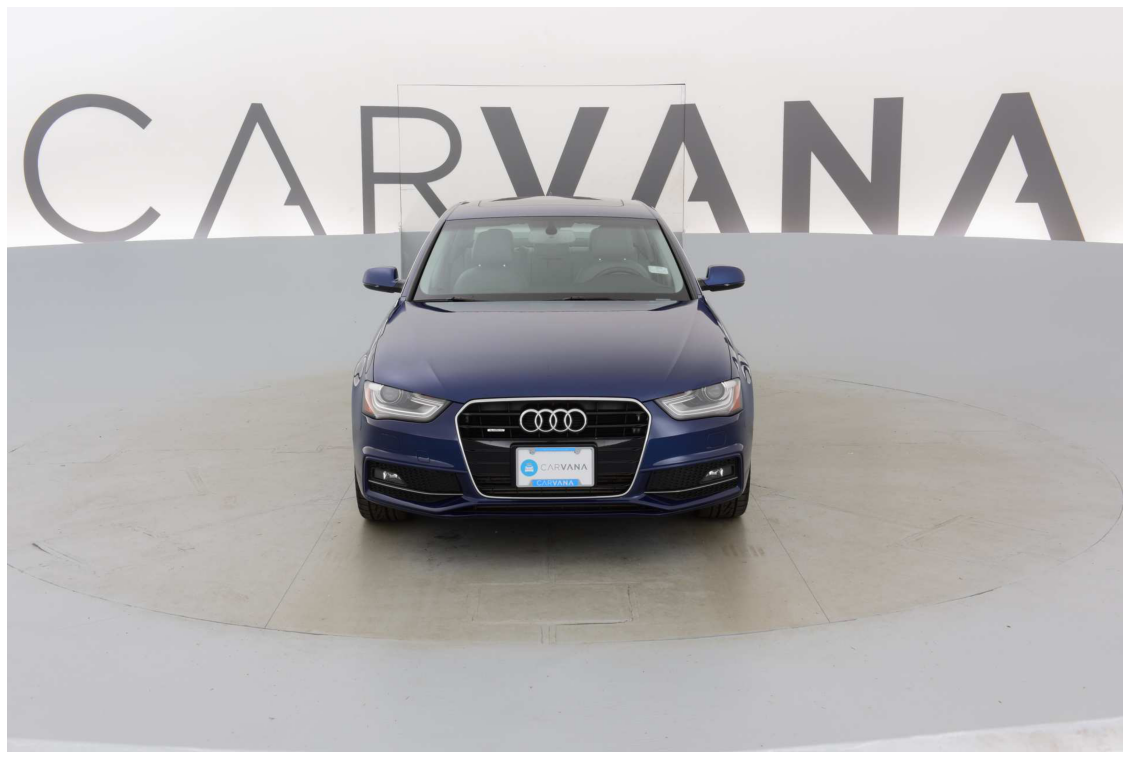

In [168]:
plt.figure(figsize=(20, 30))
input_image = Image.open(img_path)
plt.imshow(input_image)
plt.axis("off");

In [171]:
import sklearn

In [172]:
deeplabv3 = SemanticSegmentationTorchHubAPI(device=device, torchub_model="deeplabv3_resnet101")
deeplabv3_masks = deeplabv3(input_image)
deeplabv3.detach()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [173]:
upload_file_from_gdrive("1p4eEKSisibsHhbQ8jQnjcQiU-GwpisPJ", "space.jpg")

(-0.5, 1917.5, 1279.5, -0.5)

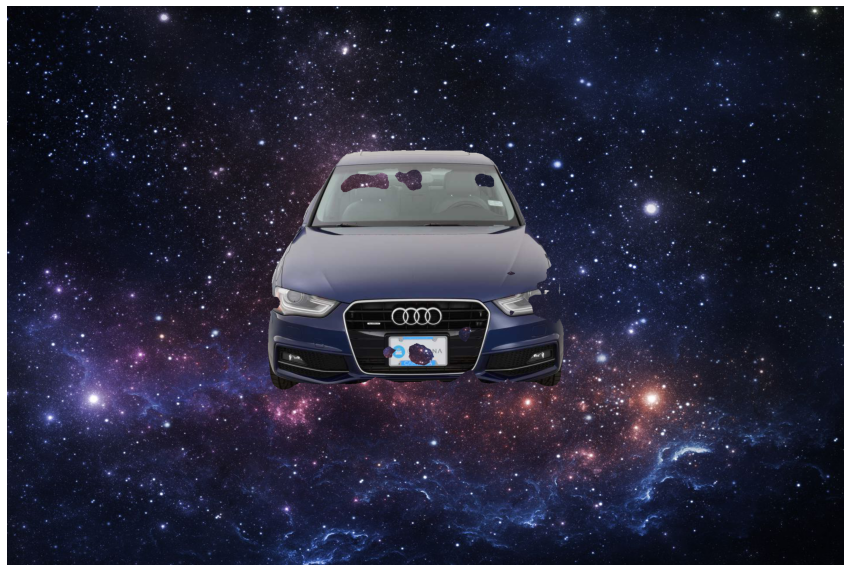

In [174]:
# Порог вероятностей классов
threshold = 0.65
# Исходная картинка
img = np.array(input_image)
# Новый фон
background = np.array(Image.open("space.jpg").resize(input_image.size))
# Образы студентов
cars = (deeplabv3_masks[7] > threshold).reshape((*img.shape[:2], 1)) * img
# Фон без студентов
background_without_students = (deeplabv3_masks[7] <= threshold).reshape((*img.shape[:2], 1)) * background

# Визуализация
plt.figure(figsize=(15, 15))
plt.imshow(cars + background_without_students)
plt.axis("off")